In [13]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [14]:
!ls -lh

total 8.0K
drwx------ 5 root root 4.0K Feb 21 16:24 drive
drwxr-xr-x 1 root root 4.0K Jan 16 14:24 sample_data


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
isic_root = "/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration"
train_dir = os.path.join(isic_root, "Train")
test_dir  = os.path.join(isic_root, "Test")

print("Train dir:", train_dir, os.listdir(train_dir))
print("Test dir :", test_dir, os.listdir(test_dir))

IMG_SIZE   = (224, 224)
BATCH_SIZE = 32

train_aug = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

val_aug = ImageDataGenerator(rescale=1./255)

isic_train = train_aug.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

isic_val = val_aug.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

NUM_CLASSES_ISIC = isic_train.num_classes
print("ISIC classes:", isic_train.class_indices)


In [ ]:
base_isic = DenseNet201(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

for layer in base_isic.layers:
    layer.trainable = False

x = base_isic.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
out_isic = Dense(NUM_CLASSES_ISIC, activation='softmax')(x)

model_isic = Model(inputs=base_isic.input, outputs=out_isic)

model_isic.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_isic.summary()


In [ ]:
base_isic = DenseNet201(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

for layer in base_isic.layers:
    layer.trainable = False

x = base_isic.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
out_isic = Dense(NUM_CLASSES_ISIC, activation='softmax')(x)

model_isic = Model(inputs=base_isic.input, outputs=out_isic)

model_isic.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_isic.summary()


In [ ]:
checkpoint_isic_path = "/content/drive/MyDrive/isic_densenet201_best.keras"

checkpoint_isic = ModelCheckpoint(
    checkpoint_isic_path,
    monitor='val_loss',
    save_best_only=True,
    mode='min'
)

early = EarlyStopping(
    monitor='val_loss',
    patience=8,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=4,
    min_lr=1e-6
)

EPOCHS_ISIC_STAGE1 = 25

history_isic_stage1 = model_isic.fit(
    isic_train,
    epochs=EPOCHS_ISIC_STAGE1,
    validation_data=isic_val,
    callbacks=[checkpoint_isic, early, reduce_lr]
)


In [ ]:
for layer in base_isic.layers[-80:]:
    layer.trainable = True

model_isic.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

EPOCHS_ISIC_STAGE2 = 20

history_isic_stage2 = model_isic.fit(
    isic_train,
    epochs=EPOCHS_ISIC_STAGE2,
    validation_data=isic_val,
    callbacks=[checkpoint_isic, early, reduce_lr]
)


In [ ]:
model_isic.load_weights(checkpoint_isic_path)

isic_final_path = "/content/drive/MyDrive/isic_densenet201_final_9class.keras"
model_isic.save(isic_final_path)

print("Saved 9-class ISIC model:", isic_final_path)


NameError: name 'model_isic' is not defined

In [ ]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    acc     = history.history.get("accuracy", [])
    val_acc = history.history.get("val_accuracy", [])
    loss    = history.history.get("loss", [])
    val_loss= history.history.get("val_loss", [])

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12,4))

    plt.subplot(1,2,1)
    plt.plot(epochs, acc, 'b-', label='Train acc')
    plt.plot(epochs, val_acc, 'r-', label='Val acc')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy vs Epochs')

    plt.subplot(1,2,2)
    plt.plot(epochs, loss, 'b-', label='Train loss')
    plt.plot(epochs, val_loss, 'r-', label='Val loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss vs Epochs')

    plt.tight_layout()
    plt.show()

# Example: To plot the history of the first stage of training:
plot_training_history(history_isic_stage1)

# To plot the history of the second stage of training:
# plot_training_history(history_isic_stage2)

NameError: name 'history_isic_stage1' is not defined

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import itertools

# Get true labels and predictions
val_steps = isic_val.samples // isic_val.batch_size + 1
y_pred_probs = model_isic.predict(isic_val, steps=val_steps)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = isic_val.classes
class_names = list(isic_val.class_indices.keys())

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix'):
    if normalize:
        cm = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis] + 1e-8)

    plt.figure(figsize=(8,6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, ha='right')
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(cm, class_names, normalize=False, title='Confusion matrix')
plot_confusion_matrix(cm, class_names, normalize=True, title='Normalized confusion matrix')

# Classification report
print(classification_report(y_true, y_pred, target_names=class_names))

NameError: name 'isic_val' is not defined

In [ ]:
from sklearn.metrics import roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt

# Assuming you want to plot ROC for the 'melanoma' class within your 9-class ISIC model
# First, identify the index for the 'melanoma' class
melanoma_class_index = isic_val.class_indices['melanoma']

# Get predictions from the ISIC model on ISIC validation data
val_steps = isic_val.samples // isic_val.batch_size + 1
y_pred_probs_multi = model_isic.predict(isic_val, steps=val_steps) # Multi-class probabilities

# Extract probabilities for the 'melanoma' class
y_prob = y_pred_probs_multi[:, melanoma_class_index]

# Get true labels and binarize them for the 'melanoma' class (1 if melanoma, 0 otherwise)
y_true_multi = isic_val.classes
y_true = (y_true_multi == melanoma_class_index).astype(int)

fpr, tpr, thresholds = roc_curve(y_true, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='AUC (Melanoma) = {:.3f}'.format(roc_auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for Melanoma class')
plt.legend(loc='best')
plt.show()


NameError: name 'isic_val' is not defined

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def show_predictions(generator, model, n_images=9):
    x_batch, y_batch = next(generator)
    y_true = np.argmax(y_batch, axis=1)
    y_pred = np.argmax(model.predict(x_batch), axis=1)
    class_names = list(generator.class_indices.keys())

    plt.figure(figsize=(12,12))
    for i in range(min(n_images, len(x_batch))):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(x_batch[i])
        true_label = class_names[y_true[i]]
        pred_label = class_names[y_pred[i]]
        color = 'green' if y_true[i] == y_pred[i] else 'red'
        plt.title(f"T: {true_label}\nP: {pred_label}", color=color)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# Example: show predictions on validation batch
show_predictions(isic_val, model_isic, n_images=9)


NameError: name 'isic_val' is not defined

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

def get_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.input],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]

    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    heatmap = np.maximum(heatmap, 0) / (tf.math.reduce_max(heatmap) + 1e-8)
    return heatmap.numpy()

def display_gradcam(generator, model, last_conv_layer_name, n_images=3):
    x_batch, y_batch = next(generator)
    class_names = list(generator.class_indices.keys())

    for i in range(min(n_images, len(x_batch))):
        img = x_batch[i]
        img_array = np.expand_dims(img, axis=0)
        preds = model.predict(img_array)
        pred_index = np.argmax(preds[0])
        pred_label = class_names[pred_index]

        heatmap = get_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index)

        heatmap = np.uint8(255 * heatmap)
        heatmap = np.expand_dims(heatmap, axis=2)
        heatmap = tf.image.resize(heatmap, (img.shape[0], img.shape[1])).numpy().astype("uint8")
        heatmap = np.squeeze(heatmap, axis=2)

        plt.figure(figsize=(6,3))
        plt.subplot(1,2,1)
        plt.imshow(img)
        plt.title(f"Original\nPred: {pred_label}")
        plt.axis("off")

        plt.subplot(1,2,2)
        plt.imshow(img)
        plt.imshow(heatmap, cmap='jet', alpha=0.4)
        plt.title("Grad-CAM")
        plt.axis("off")
        plt.tight_layout()
        plt.show()

# Example: use last conv block name from your DenseNet201
display_gradcam(isic_val, model_isic, last_conv_layer_name="conv5_block16_concat", n_images=3)


NameError: name 'isic_val' is not defined

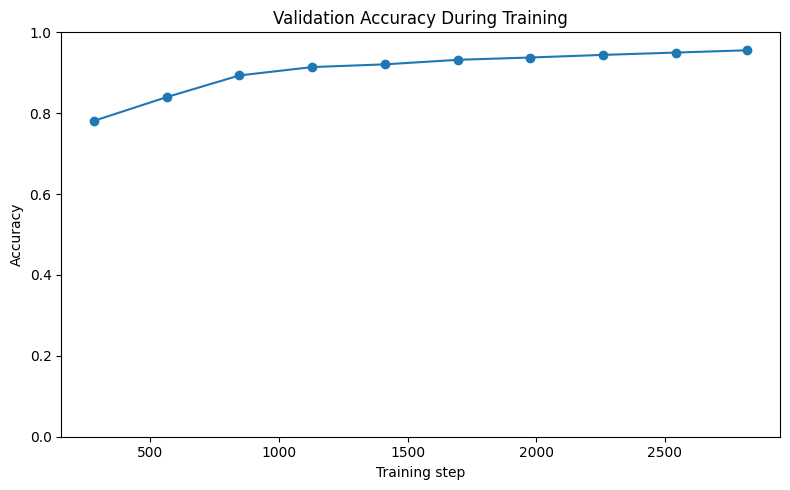

In [ ]:
if eval_accuracy:
    plt.figure(figsize=(8, 5))
    plt.plot(eval_steps[:len(eval_accuracy)], eval_accuracy, marker="o")
    plt.xlabel("Training step")
    plt.ylabel("Accuracy")
    plt.title("Validation Accuracy During Training")
    plt.ylim(0, 1.0)
    plt.tight_layout()
    plt.show()
else:
    print("No eval_accuracy found in trainer_state.json.")


In [ ]:
import json
import matplotlib.pyplot as plt

state_path = "/content/dinov2_skindisease_local/trainer_state.json"

with open(state_path, "r") as f:
    state = json.load(f)

logs = state["log_history"]

steps = []
train_loss = []
eval_steps = []
eval_loss = []
eval_accuracy = []

for log in logs:
    if "loss" in log and "step" in log:
        steps.append(log["step"])
        train_loss.append(log["loss"])
    if "eval_loss" in log and "step" in log:
        eval_steps.append(log["step"])
        eval_loss.append(log["eval_loss"])
        if "eval_accuracy" in log:
            eval_accuracy.append(log["eval_accuracy"])

# Plot loss
plt.figure(figsize=(8, 5))
if train_loss:
    plt.plot(steps, train_loss, label="Train loss")
if eval_loss:
    plt.plot(eval_steps, eval_loss, label="Validation loss", marker="o")
plt.xlabel("Training step")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.tight_layout()
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: '/content/dinov2_skindisease_local/trainer_state.json'

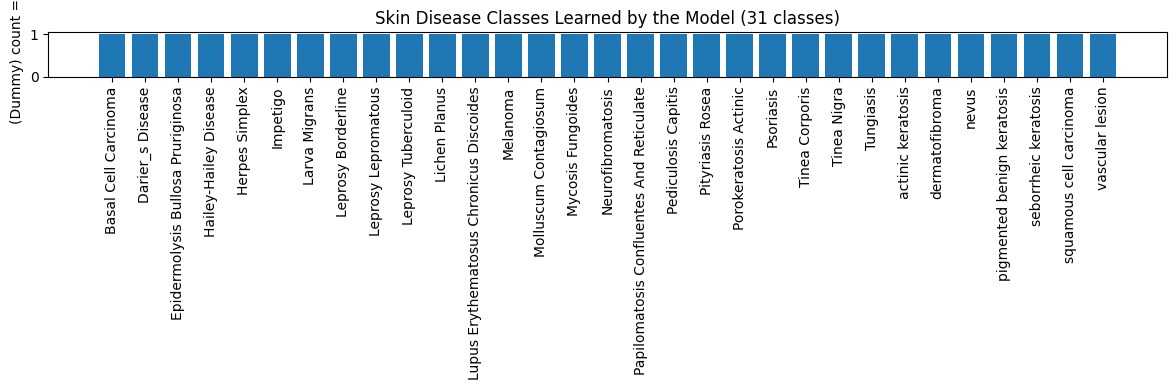

In [ ]:
import matplotlib.pyplot as plt

id2label = model.config.id2label
labels = [id2label[i] for i in range(model.config.num_labels)]

plt.figure(figsize=(12, 4))
plt.bar(range(len(labels)), [1]*len(labels))
plt.xticks(range(len(labels)), labels, rotation=90)
plt.ylabel("(Dummy) count = 1")
plt.title("Skin Disease Classes Learned by the Model (31 classes)")
plt.tight_layout()
plt.show()


In [ ]:
print("=== MODEL SUMMARY ===")
print("Base model:", model.config._name_or_path)
print("Number of labels (classes):", model.config.num_labels)

print("\nAll classes:")
for i in range(model.config.num_labels):
    print(f"{i}: {model.config.id2label[i]}")

print("\nFull model architecture:\n")
print(model)


=== MODEL SUMMARY ===
Base model: /content/dinov2_skindisease_local
Number of labels (classes): 31

All classes:
0: Basal Cell Carcinoma
1: Darier_s Disease
2: Epidermolysis Bullosa Pruriginosa
3: Hailey-Hailey Disease
4: Herpes Simplex
5: Impetigo
6: Larva Migrans
7: Leprosy Borderline
8: Leprosy Lepromatous
9: Leprosy Tuberculoid
10: Lichen Planus
11: Lupus Erythematosus Chronicus Discoides
12: Melanoma
13: Molluscum Contagiosum
14: Mycosis Fungoides
15: Neurofibromatosis
16: Papilomatosis Confluentes And Reticulate
17: Pediculosis Capitis
18: Pityriasis Rosea
19: Porokeratosis Actinic
20: Psoriasis
21: Tinea Corporis
22: Tinea Nigra
23: Tungiasis
24: actinic keratosis
25: dermatofibroma
26: nevus
27: pigmented benign keratosis
28: seborrheic keratosis
29: squamous cell carcinoma
30: vascular lesion

Full model architecture:

Dinov2ForImageClassification(
  (dinov2): Dinov2Model(
    (embeddings): Dinov2Embeddings(
      (patch_embeddings): Dinov2PatchEmbeddings(
        (projection)

In [ ]:
from transformers import AutoModel, AutoImageProcessor
model = AutoModel.from_pretrained("Jayanth2002/dinov2-base-finetuned-SkinDisease")


In [15]:
!pip install -q transformers pillow

import torch
from transformers import AutoImageProcessor, AutoModelForImageClassification
from PIL import Image

# 1. Model repo name
repo_name = "Jayanth2002/dinov2-base-finetuned-SkinDisease"

# 2. Load processor + model
processor = AutoImageProcessor.from_pretrained(repo_name)
model = AutoModelForImageClassification.from_pretrained(repo_name)
model.eval()  # inference mode


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/436 [00:00<?, ?B/s]

The image processor of type `BitImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. 


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/347M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/225 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/347M [00:00<?, ?B/s]

Dinov2ForImageClassification(
  (dinov2): Dinov2Model(
    (embeddings): Dinov2Embeddings(
      (patch_embeddings): Dinov2PatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(14, 14), stride=(14, 14))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): Dinov2Encoder(
      (layer): ModuleList(
        (0-11): 12 x Dinov2Layer(
          (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (attention): Dinov2Attention(
            (attention): Dinov2SelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): Dinov2SelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (layer_scale1): Dinov2Laye

In [16]:
save_dir = "dinov2_skindisease_local"
model.save_pretrained(save_dir)
processor.save_pretrained(save_dir)


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

['dinov2_skindisease_local/preprocessor_config.json']

In [ ]:
import shutil
from google.colab import files

output_filename = 'dinov2_skindisease_local.zip'
directory_to_zip = '/content/dinov2_skindisease_local'

# Create a zip archive of the directory
shutil.make_archive(output_filename.replace('.zip', ''), 'zip', directory_to_zip)

# Download the zip file
files.download(output_filename)

model.safetensors:   0%|          | 0.00/347M [00:00<?, ?B/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!pip install -q streamlit pyngrok transformers pillow


In [ ]:
from pyngrok import ngrok

NGROK_AUTH_TOKEN = "2udJNzJUaMmPlz2LDENZUoF1gWB_sptf75K3eyxKfFsDTFur"  # <- paste here
ngrok.set_auth_token(NGROK_AUTH_TOKEN)


In [ ]:
%%writefile app.py
import streamlit as st
from PIL import Image
import torch
from transformers import AutoImageProcessor, AutoModelForImageClassification

# ---- CONFIG ----
MODEL_DIR = "/content/dinov2_skindisease_local"

@st.cache_resource
def load_model():
    processor = AutoImageProcessor.from_pretrained(MODEL_DIR)
    model = AutoModelForImageClassification.from_pretrained(MODEL_DIR)
    model.eval()
    return processor, model

processor, model = load_model()

# Simple advice dictionary (you can customize)
def get_advice(label: str) -> str:
    label_lower = label.lower()
    if "melanoma" in label_lower:
        return "High-risk lesion suspected (melanoma). Advise urgent dermatology consultation and biopsy."
    if "nevus" in label_lower or "naevus" in label_lower or "nevus" in label_lower:
        return "Likely benign nevus. Monitor for changes in size, color, or border; seek dermatology review if evolving."
    if "bcc" in label_lower or "basal cell" in label_lower:
        return "Possible basal cell carcinoma. Recommend dermatology visit for confirmation and local treatment."
    if "psoriasis" in label_lower:
        return "Features suggest psoriasis. Consult dermatologist for topical/systemic therapy options."
    if "eczema" in label_lower or "dermatitis" in label_lower:
        return "Looks like eczema/dermatitis. Emollients and topical steroids may help; confirm with a clinician."
    return "AI-based suggestion only. Please consult a qualified dermatologist for confirmation and treatment."

st.set_page_config(page_title="AI Skin Disease Assistant", layout="wide")

st.title("AI Skin Disease Assistant (Demo)")
st.write("Upload a skin lesion image and enter basic patient details to get an AI-based classification and advice. This is **not** a medical diagnosis.")

# --- Patient data form ---
with st.form("patient_form"):
    col1, col2 = st.columns(2)
    with col1:
        name = st.text_input("Patient Name", "")
        age = st.number_input("Age", min_value=0, max_value=120, value=30)
        gender = st.selectbox("Gender", ["Male", "Female", "Other"])
    with col2:
        duration = st.text_input("Duration of lesion (e.g., 2 weeks)")
        location = st.text_input("Location on body (e.g., back, leg)")
        symptoms = st.text_area("Symptoms (itching, pain, bleeding, etc.)")

    uploaded_file = st.file_uploader("Upload a skin lesion image", type=["jpg", "jpeg", "png"])
    submitted = st.form_submit_button("Analyze")

if submitted:
    if uploaded_file is None:
        st.error("Please upload an image first.")
    else:
        # Show patient summary
        st.subheader("Patient Information")
        st.write(f"**Name:** {name if name else 'N/A'}")
        st.write(f"**Age:** {age}")
        st.write(f"**Gender:** {gender}")
        st.write(f"**Duration:** {duration if duration else 'N/A'}")
        st.write(f"**Location:** {location if location else 'N/A'}")
        st.write(f"**Symptoms:** {symptoms if symptoms else 'N/A'}")

        # Read and show image
        image = Image.open(uploaded_file).convert("RGB")
        st.subheader("Uploaded Image")
        st.image(image, use_column_width=True)

        # Preprocess and run inference
        with st.spinner("Analyzing image with AI model..."):
            inputs = processor(images=image, return_tensors="pt")
            with torch.no_grad():
                outputs = model(**inputs)
                logits = outputs.logits
                probs = logits.softmax(dim=-1)[0]
                pred_idx = int(torch.argmax(probs).item())
                pred_label = model.config.id2label[pred_idx]
                pred_conf = float(probs[pred_idx].item())

        st.subheader("AI Prediction")
        st.write(f"**Predicted Class:** {pred_label}")
        st.write(f"**Confidence:** {pred_conf*100:.2f}%")

        # Show top-3 classes
        st.write("**Top 3 probable classes:**")
        topk = torch.topk(probs, k=min(3, probs.shape[0]))
        for score, idx in zip(topk.values, topk.indices):
            lbl = model.config.id2label[int(idx)]
            st.write(f"- {lbl}: {float(score)*100:.2f}%")

        # Advice
        st.subheader("AI Advice (Not a Diagnosis)")
        st.write(get_advice(pred_label))
        st.info("This tool is for educational and research purposes only. Always consult a dermatologist for actual medical decisions.")


Overwriting app.py


In [ ]:
import threading
import time
import subprocess
from pyngrok import ngrok

# 1. Kill any previous tunnels
ngrok.kill()

# 2. Function to run streamlit
def run_streamlit():
    cmd = ["streamlit", "run", "app.py", "--server.port", "8501", "--server.headless", "true"]
    subprocess.Popen(cmd)

# 3. Start streamlit in background
thread = threading.Thread(target=run_streamlit, daemon=True)
thread.start()

# 4. Wait a bit for server to start
time.sleep(5)

# 5. Create ngrok tunnel
public_url = ngrok.connect(8501)
print("Public URL:", public_url)


Public URL: NgrokTunnel: "https://2d43c076d7bc.ngrok-free.app" -> "http://localhost:8501"
